# examine outputs

In [ ]:
import json
from collections import defaultdict

stats = {
    'problems': 0,
    'total_gens': 0,
    'total_tests': 0,
    'passed_tests': 0,
}
errors = defaultdict(int)
test_results = []

with open('outputs/70b_test.jsonl', 'r') as f:
    for line in f:
        o = json.loads(line)
        stats['problems'] += 1
        num_gens = len(o['results'])
        stats['total_gens'] += num_gens
        
        for r in o['results']:
            if r['code_error']: 
                errors[r['code_error']] += 1
                continue
                
            num_tests = len(r['test_results'])
            stats['total_tests'] += num_tests
            stats['passed_tests'] += r['pass']
            
            for i, (result, _) in enumerate(r['test_results']):
                while len(test_results) <= i:
                    test_results.append({'pass': 0, 'total': 0})
                test_results[i]['total'] += 1
                if result == 'pass':
                    test_results[i]['pass'] += 1

print(f"Problems: {stats['problems']}")
print(f"Generations: {stats['total_gens']}")
print(f"Pass rate: {stats['passed_tests'] / stats['total_tests']:.1%}")

print("\nPass rate by test position:")
for i, res in enumerate(test_results):
    rate = res['pass'] / res['total']
    bar = '#' * int(rate * 40)
    print(f"Test {i+1}: {rate:.1%} |{bar:<40}|")

print("\nTop errors:")
for err, count in sorted(errors.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"- {err}: {count}")

# compute winrates

/usr/local/anaconda3/envs/llmr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


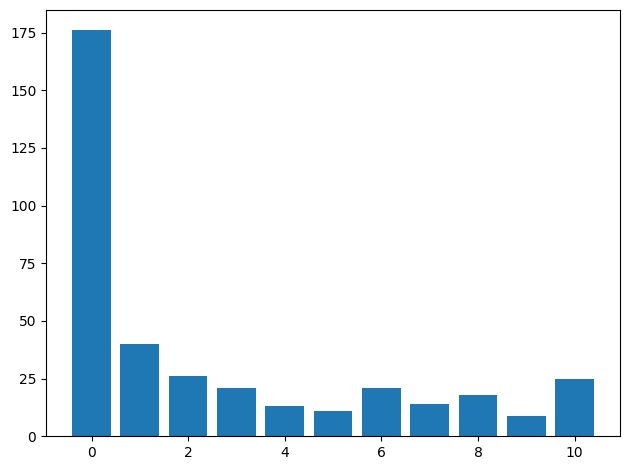

In [1]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from sample import format_prompt

def compare(gen1, gen2, tok1, tok2):
    if not gen1.get('code_error') and not gen2.get('code_error'):
        if gen1['pass'] != gen2['pass']:
            return gen1['pass'] > gen2['pass']
        return tok1 <= tok2
    if gen1.get('code_error') is None and gen2.get('code_error') is None:
        raise Exception('both failed')
    return not gen1.get('code_error')

file1 = 'outputs/1b_train_outputs.jsonl'
file2 = 'outputs/70b_train_outputs.jsonl'
output = 'outputs/1b_70b_wins.jsonl'

win_freq = defaultdict(int)
with open(file1) as f1, open(file2) as f2, open(output, 'w') as f_out:
    for line1, line2 in zip(f1, f2):
        o1, o2 = json.loads(line1), json.loads(line2)
        prompt = format_prompt(o1['item'])
        wins = sum(compare(*pair) for pair in zip(o1['results'], o2['results'], o1['num_tokens'], o2['num_tokens']))
        win_freq[wins] += 1
        json.dump({'prompt': prompt, 'target': wins / 10}, f_out)
        f_out.write('\n')

k, v = zip(*list(sorted(win_freq.items(), key=lambda x: x[0])))
plt.bar(list(k), list(v))
plt.tight_layout()
plt.savefig('figures/1b_70b_wins.png')